Apache Spark — фреймворк с открытым исходным кодом для реализации распределённой обработки неструктурированных и слабоструктурированных данных, входящий в экосистему проектов Hadoop. В отличие от классического обработчика из ядра Hadoop, реализующего двухуровневую концепцию MapReduce с хранением промежуточных данных на накопителях, Spark работает в парадигме резидентных вычислений — обрабатывает данные в оперативной памяти.

Spark реализует парадигму отложенных или ленивых вычислений. Вычисления начнутся только после явного указания действий - collect, show, count, write, toPandas.  

In [1]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = (
        SparkSession
        .builder
        .config(
            conf=SparkConf()
            .setAppName('spark-test-app')
            .set("spark.yarn.queue", "root.ke.dev")
        ).getOrCreate()
)


In [2]:
spark.sql("show databases").show(10, False)

+------------------+
|namespace         |
+------------------+
|1c_data           |
|1c_data_private   |
|aer_adm_sg        |
|aer_ads_sg        |
|aer_ba_sg         |
|aer_bi_sg         |
|aer_cdm_sg        |
|aer_cdm_sg_private|
|aer_cdmx_sg       |
|aer_ds_sg         |
+------------------+
only showing top 10 rows



In [3]:
spark.stop()

# Spark setttings

In [3]:
!cat /opt/spark/conf/spark-defaults.conf

## managed by puppet

spark.master yarn
spark.io.compression.codec org.apache.spark.io.SnappyCompressionCodec
spark.serializer org.apache.spark.serializer.KryoSerializer
spark.yarn.queue ad-hoc
spark.yarn.maxAppAttempts 1
spark.sql.warehouse.dir hdfs:///apps/hive/warehouse
spark.eventLog.enabled true
spark.yarn.historyServer.address spark-hst-ui1z3.h.ae-rus.net:18088
spark.history.ui.port 18088
spark.history.fs.logDirectory hdfs:///spark-history
spark.eventLog.dir hdfs:///spark-history
spark.eventLog.permissions 777
spark.history.fs.cleaner.enabled true
spark.history.fs.cleaner.interval 1d
spark.history.fs.cleaner.maxAge 7d
spark.shuffle.manager SORT
spark.shuffle.consolidateFiles true
spark.shuffle.service.enabled true
spark.shuffle.registration.timeout 30000
spark.shuffle.registration.maxAttempts 3
spark.shuffle.io.maxRetries 3
spark.shuffle.io.numConnectionsPerPeer 5
spark.sql.adaptive.enabled true
spark.sql.adaptive.coalescePartitions.enabled true
spark.sql.adaptive.coalescePartiti

- `spark.master`: `yarn`, variants: standalone, yarn, kubernetes. https://spark.apache.org/docs/latest/cluster-overview.html#cluster-manager-types
- `spark.deploy-mode`: `client`. In cluster mode, the Spark driver runs inside an application master process which is managed by YARN on the cluster, and the client can go away after initiating the application. In client mode, the driver runs in the client process, and the application master is only used for requesting resources from YARN. https://spark.apache.org/docs/latest/running-on-yarn.html
- `spark.yarn.queue`: The name of the YARN queue to which the application is submitted.
- `spark.driver.memory`: Amount of memory to use for the driver process, i.e. where SparkContext is initialized, in the same format as JVM memory strings with a size unit suffix ("k", "m", "g" or "t") (e.g. 512m, 2g). In client mode, this config must not be set through the SparkConf directly in your application, because the driver JVM has already started at that point. Instead, please set this through the --driver-memory command line option or in your default properties file. Be careful with values above "32g"! At least ~47 GB required to get the same storage
- `spark.executor.memory`: Amount of memory to use per executor process, in the same format as JVM memory strings with a size unit suffix ("k", "m", "g" or "t") (e.g. 512m, 2g).
- `spark.executor.memory_overhead`: Amount of non-heap memory to be allocated per driver process in cluster mode, in MiB unless otherwise specified. This is memory that accounts for things like VM overheads, interned strings, other native overheads, etc. This tends to grow with the container size (typically 6-10%). This option is currently supported on YARN, Mesos and Kubernetes. Note: Non-heap memory includes off-heap memory (when spark.memory.offHeap.enabled=true) and memory used by other driver processes (e.g. python process that goes with a PySpark driver) and memory used by other non-driver processes running in the same container. The maximum memory size of container to running driver is determined by the sum of spark.driver.memoryOverhead and spark.driver.memory.
- `spark.dynamicAllocation.enabled`: sometimes dynamic allocation causes instability. Needs `spark.shuffle.service.enabled` set to True
- `spark.driver.cores`: Number of cores to use for the driver process, only in cluster mode.
- `spark.executor.cores`: The number of cores to use on each executor
- `spark.sql.shuffle.partitions`: The default number of partitions to use when shuffling data for joins or aggregations.
- `spark.default.parallelism`: Default number of partitions in RDDs returned by transformations like join, reduceByKey, and parallelize when not set by user.
- `spark.stage.maxConsecutiveAttempts`: Number of consecutive stage attempts allowed before a stage is aborted.

Dynamic partitioning means the partitions are not configured before execution else it is made during run time depending on the size of file or partitions required. It ensures the best way of the utilization of RAM and the distribution of memory. Dynamic partitioning allows overwtiting only needed partitions instead of ALL TABLE
- `spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")`
- `hiveContext.setConf("hive.exec.dynamic.partition", "true")`
- `hiveContext.setConf("hive.exec.dynamic.partition.mode", "nonstrict")`

Broadcast tables
- `spark.sql.autoBroadcastJoinThreshold`: Configures the maximum size in bytes for a table that will be broadcast to all worker nodes when performing a join. By setting this value to -1 broadcasting can be disabled. May cause OOM

Dynamic allocation is pure evil! When you start loading data into memory it will load on fewer number of executors then it will further work. Thus not all executors will took part in all calculations. Data will be disbalanced between executors.

- `spark.dynamicAllocation.minExecutors`
- `spark.dynamicAllocation.maxExecutors`
- `spark.dynamicAllocation.initialExecutors`
- `spark.executor.instances`: for static allocation
- `spark.dynamicAllocation.executorIdleTimeout` set to 120s, if executor is idle for this time, it will be returned to pool
- `spark.dynamicAllocation.cachedExecutorIdleTimeout` set to 600s, if executir is idle but has cached information, discard it and return executor to pool


- `spark.port.maxRetries`: 200. Maximum number of retries when binding to a port before giving up. When a port is given a specific value (non 0), each subsequent retry will increment the port used in the previous attempt by 1 before retrying.
- `spark.serializer`: KryoSerializer instead of JavaSerializer; docs advise to use KryoSerializer when speed is required
- `spark.eventLog.enabled`: `true`. Whether to log Spark events, useful for reconstructing the Web UI after the application has finished.
- `spark.io.compression.codec`: Snappy or lz4 recommended
- `spark.yarn.am.memory`, `spark.yarn.am.cores`: ApplicationMaster settings
- `spark.sql.autoBroadcastJoinThreshold` sometimes throw OOM errors with no evident reason
- `spark.shuffle.reduceLocality.enabled = False` - equally repartition small dataframes between executors, currently maybe useless

https://spark.apache.org/docs/latest/running-on-yarn.html

https://spark.apache.org/docs/latest/configuration.html

https://spark.apache.org/docs/latest/monitoring.html

At this moment something went wrong... So, we'll distribute our own environment and try to use UDFs

# Distribute your environment on cluster nodes

1. Install your conda
2. `conda create -n pyspark_env python=3.8.5 numpy pandas scikit-learn scipy pyarrow conda-pack`
3. `conda pack -n pyspark_env -o pyspark_env.tar.gz`

In [1]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f, types as t, Window as w

import re
import pandas as pd
import time
import uuid

import os
os.environ["PYSPARK_PYTHON"] = "./environment/bin/python"

In [2]:
memory = '10g'
memory_overhead = '1g'
executor_memory = '5g'
cores = 4
num_executors = 50
app_name = "spark-test-app"
queue = 'root.ke.dev'
dynamic_allocation = False
env_archive = "https://nexus/environments/latest.tar.gz#environment"

def get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, 
    dynamic_allocation = False, parallelism=None, env_archive=None, broadcasting=True
):
    if not parallelism: 
        parallelism = cores * num_executors
    
    config = (
        SparkConf()
        .setMaster("yarn")
        .setAppName(app_name)
        .set("spark.yarn.queue", queue)
        .set('spark.network.timeout', "300s")
        .set('spark.executor.heartbeatInterval', "10s")
        .set('spark.driver.memory', memory)
        .set('spark.driver.memoryOverhead', memory_overhead)
        .set('spark.driver.maxResultSize', memory)
        .set('spark.executor.memory', executor_memory)
        .set('spark.executor.memoryOverhead', memory_overhead)
        .set('spark.sql.shuffle.partitions', parallelism)
        .set('spark.default.parallelism', parallelism)
        .set('spark.driver.cores', cores)
        .set('spark.executor.cores', cores)
        .set("spark.executor.instances", num_executors)
        .set("spark.stage.maxConsecutiveAttempts", 10)
        .set("spark.rpc.io.serverThreads", 64)
        .set('spark.sql.hive.convertMetastoreOrc', 'true')
        .set('spark.sql.orc.impl', 'native')
        .set('spark.sql.orc.enableVectorizedReader', 'true')
        .set("spark.sql.execution.arrow.enabled", "true")  # optimize spark -> pandas transfer
    )
    
    if dynamic_allocation is True:
        (
            config
            .set('spark.dynamicAllocation.enabled', True)
            .set("spark.shuffle.service.enabled", True)
            .set("spark.dynamicAllocation.minExecutors", min(1, num_executors // 10))
            .set("spark.dynamicAllocation.maxExecutors", num_executors)
        )
    if env_archive:
        config.set("spark.yarn.dist.archives", env_archive)
        
    if not broadcasting:
        (
            config
            .set("spark.sql.autoBroadcastJoinThreshold", -1)
            .set("spark.shuffle.reduceLocality.enabled", False)
        )
        
    spark = (
        SparkSession
        .builder
        .config(conf=config)
        .enableHiveSupport()
        .getOrCreate()
    )
    return spark


In [ ]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive
)

In [4]:
spark

In [5]:
@f.udf(t.StringType())
def get_ds(partition):
    if partition is not None:
        partitions = partition.split('/')
        ds = [partition for partition in partitions if 'ds' in partition]
        if ds:
            return ds[0]
    return None

def max_pt(table):
    return spark.sql(f'show partitions {table}').select(f.max(get_ds('partition'))).collect()[0][0]

# Read table

In [12]:
# Ужасно плохо. Если взять таблицу побольше размером, то можно никогда не дождаться результатов. 

start = time.time()
spark.sql("SELECT COUNT(1) FROM ke_matcher.ali_item_list_df WHERE ds == (SELECT MAX(ds) FROM ke_matcher.ali_item_list_df)").show()
print(time.time() - start)

+----------+
|  count(1)|
+----------+
|2139736585|
+----------+

74.76589632034302


In [13]:
start = time.time()
spark.sql("SELECT COUNT(1) FROM ke_matcher.ali_item_list_df WHERE ds == 20240715").show()
print(time.time() - start)

+----------+
|  count(1)|
+----------+
|2137597315|
+----------+

7.151587009429932


In [14]:
start = time.time()
print(spark.table("ke_matcher.ali_item_list_df").where(max_pt("ke_matcher.ali_item_list_df")).count())
print(time.time() - start)

2139736585
11.14228105545044


In [15]:
# Хорошо использовать, когда один и тот же DataFrame используется дальше по коду несколько раз
# Помним про ленивые вычисления. Все еще ничего не происходит!
start = time.time()
df = spark.table("ke_matcher.ali_item_list_df").where(max_pt("ke_matcher.ali_item_list_df")).cache()
print(time.time() - start)

5.821369171142578


In [16]:
# А вот теперь считаем. Первый раз результат считается долго, но сохраняется в памяти...
start = time.time()
print(df.count())
print(time.time() - start)

2139736585
73.4445469379425


In [17]:
# ... зато в следующий раз все происходит значительно быстрее
start = time.time()
print(df.count())
print(time.time() - start)

2139736585
0.6030876636505127


In [18]:
df.unpersist()

DataFrame[item_id: string, is_updated: string, ds: string, is_online: string]

In [19]:
df = spark.sql("SELECT * FROM ke_matcher.ali_item_list_df WHERE ds == 20240715")
df.createOrReplaceTempView("tmp_table")
spark.sql("SELECT * FROM tmp_table").show(3, truncate=True, vertical=False)

+------------------+----------+--------+---------+
|           item_id|is_updated|      ds|is_online|
+------------------+----------+--------+---------+
|0_1005004567140226|         N|20240715|        N|
|     0_32411785507|         N|20240715|        N|
|0_3256804461453097|         N|20240715|        N|
+------------------+----------+--------+---------+
only showing top 3 rows



# Data types

In [21]:
bizdate = "20240715"
df = spark.table("dwh.dim_item_active").where(f.col("ds") == bizdate)
type(df)

pyspark.sql.dataframe.DataFrame

In [22]:
df = spark.sql("select * from dwh.dim_item_active where ds == 20240715")
type(df)

pyspark.sql.dataframe.DataFrame

# Save table

- mode: `append`,  `overwrite`, `ignore`, `error` or `errorifexists`
- format: `orc`, `parquet`, ...

```df.write.format("parquet").mode("overwrite").partitionBy("partition_cols").insertInto("table_name")```

```df.write.format("parquet").save("df_name.parquet")```

```df.write.mode("overwrite").orc("df_name.orc")```

```df.write.mode("append").saveAsTable("table_name")```

```df.write.insertInto("table_name", overwrite=True)  # needs dynamic partitioning: hive.exec.dynamic.partition set to true, hive.exec.dynamic.partition.mode set to nonstrict```

С последним методом моожно получить неожиданный результат. Если неправильно выставить параметры, можно перезаписать не партицию, а всю таблицу

Никогда не мог запомнить все многообразие, поэтому у нас в команде таблицы сохраняются так:

- если таблица не существует, то мы создаем пустой датафрейм с нужной схемой и сохраняем его в таблицу ```empty_df.write.saveAsTable("table_name", mode="overwrite", partitionBy=["col1", "col2", ...])```

- записываем новую партицию в таблицу: ```df.write.insertInto("table_name", overwrite=True)```

## Подводные камни

Spark глубоко плевать на названия колонок. Главное, чтобы сошлись их типы. Поэтому рекомендую всегда явно делать селект с правильной последовательностью колонок перед сохранением таблицы либо перед union 

## Партицирование и бакетирование таблиц

Таблицы хранятся в pyspark в виде набора файлов. 

Партицирование позволяет разбить таблицу на части в соответствии с каким-то правилом. Например, по дате. 

Тогда, чтобы прочитать данные за нужную дату, spark не требуется прочитать все файлы и использовать только какие-то определенные. Ему достаточно прочитать все файлы из определенного подкаталога

In [39]:
# Непартицированная таблица
!hdfs dfs -find /apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/autoru_cars | head -n 5

/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/autoru_cars
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/autoru_cars/000000_0
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/autoru_cars/000001_0
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/autoru_cars/000002_0
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/autoru_cars/000003_0


In [40]:
# Партицированная таблица
!hdfs dfs -find /apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/ | head -n 10

/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/_SUCCESS
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/model_id=ViT-B%2F32
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/model_id=ViT-B%2F32/prompt_id=e387a391ec490aade800df0aa24134da
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/model_id=ViT-B%2F32/prompt_id=e387a391ec490aade800df0aa24134da/colors_id=b2c6fa1a1c90224d6bdd294f60719f19
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/model_id=ViT-B%2F32/prompt_id=e387a391ec490aade800df0aa24134da/colors_id=b2c6fa1a1c90224d6bdd294f60719f19/ds=20221201
/apps/hive/dev/ke_matcher_team/ke_matcher_adhoc.db/colors_toloka_results/model_id=ViT-B%2F32/prompt_id=e387a391ec490aade800df0aa24134da/colors_id=b2c6fa1a1c90224d6bdd294f60719f19/ds=20221201/part-00000-18e3cb69-b766-40df-ad87-df3d14399909.c000.sn

При бакетировании данные в файлах распределяются в соответствии с хэшем от заданной колонки. При одинаковом хэше данные попадут в одинаковый бакет. 

За счет бакетирования можно ускорить операции типа джойнов. 

```
someDF.write.format("parquet")
      .bucketBy(4, "country")
      .mode(SaveMode.OverWrite)
      .saveAsTable("someTable")
```

```
someDF.write.format("parquet")
      .partitionBy("country")
      .mode(SaveMode.OverWrite)
      .saveAsTable("someTable")
```

## Размер файлов

Данные хранятся на hdfs. У hdfs есть ограничение - минимальный размер файла 128Mb. Если данных даже 1 байт, все равно будет записано 128 Mb. 

После чтения таблицы или джойнов количество партиций будет равно spark.sql.shuffle.partitions, что в ряде случаев может привести к возникновению огромного числа мелких файлов. 

Если сделать df.repartition(repartition_num, *repartition_cols) перед сохранением таблицы, то можно сделать сохраняемые файлы адекватного размера (512Мб - 1Гб)

# UDF introduction

Все встроенные udf (pyspark.sql.functional) почти всегда будут быстрее тех, что написали вы. Поэтому старайтесь найти то, что нужно, в стандартных функциях. 

In [9]:
df = pd.DataFrame(
    [
        [1, 'a', "ru : Продукты питания, pt : Alimentos, in : Makanan"], 
        [2, 'd', "en : Food, it : Cibo"], 
        [3, 'b', "fr : Alimentaire, ru : Продукты питания"], 
        [4, 'c', "es : Alimentos, uk : Харчування, in : Makanan, pt : Alimentos"], 
        [5, 'a', "pl : Żywności, nl : voedsel, tr : Gıda, pt : Alimentos"]
        ],
    columns=['a', 'b', 'c']
)
df

,a,b,c
0,1,a,"ru : Продукты питания, pt : Alimentos, in : Ma..."
1,2,d,"en : Food, it : Cibo"
2,3,b,"fr : Alimentaire, ru : Продукты питания"
3,4,c,"es : Alimentos, uk : Харчування, in : Makanan,..."
4,5,a,"pl : Żywności, nl : voedsel, tr : Gıda, pt : A..."


In [16]:
# spark doesn't check column names!
schema = t.StructType([
    t.StructField('a', t.IntegerType()),
    t.StructField('b', t.StringType()),
    t.StructField('c', t.StringType()),
])

# schema is optional, but now spark doesn't need to create subsample and check columns types
spark_df = spark.createDataFrame(df, schema=schema)

In [17]:
spark_df.show(3, truncate=False)

+---+---+---------------------------------------------------+
|a  |b  |c                                                  |
+---+---+---------------------------------------------------+
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan|
|2  |d  |en : Food, it : Cibo                               |
|3  |b  |fr : Alimentaire, ru : Продукты питания            |
+---+---+---------------------------------------------------+
only showing top 3 rows



## Simple UDF

In [18]:
test_udf = f.udf(lambda x: x**2 if x is not None else None, t.LongType())

In [19]:
spark_df.select("a", test_udf("a")).show(5, False)

+---+-----------+
|a  |<lambda>(a)|
+---+-----------+
|1  |1          |
|2  |4          |
|3  |9          |
|4  |16         |
|5  |25         |
+---+-----------+



## Multiple columns in UDF?

In [20]:
@f.udf(t.StructType([t.StructField("foo", t.LongType(), False), t.StructField("bar", t.LongType(), False)]))
def multiple_values_udf(x):
    return (x // 2, x % 2) if x else (float('nan'), float('nan'))

In [21]:
spark_df.select('a', multiple_values_udf('a').alias('baz')).show(5)
spark_df.select('a', multiple_values_udf('a').alias('baz')).printSchema()

+---+------+
|  a|   baz|
+---+------+
|  1|{0, 1}|
|  2|{1, 0}|
|  3|{1, 1}|
|  4|{2, 0}|
|  5|{2, 1}|
+---+------+

root
 |-- a: integer (nullable = true)
 |-- baz: struct (nullable = true)
 |    |-- foo: long (nullable = false)
 |    |-- bar: long (nullable = false)



In [23]:
spark_df.select('a', multiple_values_udf('a').alias('baz')).select("a", "baz.foo", 'baz.bar').show(5)

+---+---+---+
|  a|foo|bar|
+---+---+---+
|  1|  0|  1|
|  2|  1|  0|
|  3|  1|  1|
|  4|  2|  0|
|  5|  2|  1|
+---+---+---+



## Return dict

In [24]:
@f.udf(t.MapType(t.StringType(), t.StringType()))
def parse_feature(s):
    features = {}
    if isinstance(s, str):
        for subs in s.split(','):
            subs_split = subs.split(':')
            features[subs_split[0].lower().strip()] = subs_split[1].strip()
    return features


In [25]:
spark_df.select("c", parse_feature("c").alias("lang_dict")).show(3, False)

+---------------------------------------------------+--------------------------------------------------------+
|c                                                  |lang_dict                                               |
+---------------------------------------------------+--------------------------------------------------------+
|ru : Продукты питания, pt : Alimentos, in : Makanan|{ru -> Продукты питания, pt -> Alimentos, in -> Makanan}|
|en : Food, it : Cibo                               |{en -> Food, it -> Cibo}                                |
|fr : Alimentaire, ru : Продукты питания            |{fr -> Alimentaire, ru -> Продукты питания}             |
+---------------------------------------------------+--------------------------------------------------------+
only showing top 3 rows



In [26]:
new_df = (
    spark_df
    .select(
        "a", 
        "b", 
        "c", 
        f.explode(parse_feature("c")).alias("res_language", "category_desc"))
)

In [27]:
new_df.show(100, False)

+---+---+-------------------------------------------------------------+------------+----------------+
|a  |b  |c                                                            |res_language|category_desc   |
+---+---+-------------------------------------------------------------+------------+----------------+
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |ru          |Продукты питания|
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |pt          |Alimentos       |
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |in          |Makanan         |
|2  |d  |en : Food, it : Cibo                                         |en          |Food            |
|2  |d  |en : Food, it : Cibo                                         |it          |Cibo            |
|3  |b  |fr : Alimentaire, ru : Продукты питания                      |fr          |Alimentaire     |
|3  |b  |fr : Alimentaire, ru : Продукты питания                      |ru         

# Aggregation and window functions

In [28]:
(
    new_df
    .groupBy('res_language')  # may be multiple columns
    .agg(f.collect_list('a'), f.collect_set('category_desc'))
    .withColumnRenamed('res_language', 'language')
).show(100, False)

+--------+---------------+--------------------------+
|language|collect_list(a)|collect_set(category_desc)|
+--------+---------------+--------------------------+
|pt      |[4, 1, 5]      |[Alimentos]               |
|in      |[4, 1]         |[Makanan]                 |
|es      |[4]            |[Alimentos]               |
|uk      |[4]            |[Харчування]              |
|ru      |[1, 3]         |[Продукты питания]        |
|fr      |[3]            |[Alimentaire]             |
|it      |[2]            |[Cibo]                    |
|en      |[2]            |[Food]                    |
|tr      |[5]            |[Gıda]                    |
|nl      |[5]            |[voedsel]                 |
|pl      |[5]            |[Żywności]                |
+--------+---------------+--------------------------+



In [29]:
new_df_rn = (
    new_df
    .withColumn(
        'rn', f.row_number().over(
            w.partitionBy("res_language").orderBy(f.length('c').desc())
        )
    )
)
new_df_rn.show(100, False)

+---+---+-------------------------------------------------------------+------------+----------------+---+
|a  |b  |c                                                            |res_language|category_desc   |rn |
+---+---+-------------------------------------------------------------+------------+----------------+---+
|2  |d  |en : Food, it : Cibo                                         |en          |Food            |1  |
|4  |c  |es : Alimentos, uk : Харчування, in : Makanan, pt : Alimentos|es          |Alimentos       |1  |
|3  |b  |fr : Alimentaire, ru : Продукты питания                      |fr          |Alimentaire     |1  |
|4  |c  |es : Alimentos, uk : Харчування, in : Makanan, pt : Alimentos|in          |Makanan         |1  |
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |in          |Makanan         |2  |
|2  |d  |en : Food, it : Cibo                                         |it          |Cibo            |1  |
|5  |a  |pl : Żywności, nl : voedsel, tr : Gıd

# Pivot

In [82]:
data = [
    ("Banana", 1000, "USA"), ("Carrots", 1500, "USA"), ("Beans", 1600, "USA"),
    ("Orange", 2000, "USA"),("Orange", 2000, "USA"),("Banana", 400, "China"),
    ("Carrots", 1200, "China"),("Beans", 1500, "China"),("Orange", 4000, "China"),
    ("Banana", 2000, "Canada"),("Carrots", 2000, "Canada"),("Beans", 2000, "Mexico")
]
columns = ["Product","Amount","Country"]
df = spark.createDataFrame(data=data, schema=columns)
df.printSchema()
df.show(truncate=False)


root
 |-- Product: string (nullable = true)
 |-- Amount: long (nullable = true)
 |-- Country: string (nullable = true)

+-------+------+-------+
|Product|Amount|Country|
+-------+------+-------+
|Banana |1000  |USA    |
|Carrots|1500  |USA    |
|Beans  |1600  |USA    |
|Orange |2000  |USA    |
|Orange |2000  |USA    |
|Banana |400   |China  |
|Carrots|1200  |China  |
|Beans  |1500  |China  |
|Orange |4000  |China  |
|Banana |2000  |Canada |
|Carrots|2000  |Canada |
|Beans  |2000  |Mexico |
+-------+------+-------+



In [83]:
pivotDF = df.groupBy("Product").pivot("Country").sum("Amount")
pivotDF.printSchema()
pivotDF.show(truncate=False)

root
 |-- Product: string (nullable = true)
 |-- Canada: long (nullable = true)
 |-- China: long (nullable = true)
 |-- Mexico: long (nullable = true)
 |-- USA: long (nullable = true)

+-------+------+-----+------+----+
|Product|Canada|China|Mexico|USA |
+-------+------+-----+------+----+
|Orange |null  |4000 |null  |4000|
|Banana |2000  |400  |null  |1000|
|Carrots|2000  |1200 |null  |1500|
|Beans  |null  |1500 |2000  |1600|
+-------+------+-----+------+----+



In [84]:
pivotDF = (
    df
    .groupBy("Product","Country")
    .sum("Amount")
    .groupBy("Product")
    .pivot("Country")
    .sum("sum(Amount)")
)

pivotDF.show(truncate=False)

+-------+------+-----+------+----+
|Product|Canada|China|Mexico|USA |
+-------+------+-----+------+----+
|Orange |null  |4000 |null  |4000|
|Banana |2000  |400  |null  |1000|
|Carrots|2000  |1200 |null  |1500|
|Beans  |null  |1500 |2000  |1600|
+-------+------+-----+------+----+



# PandasUDF

Pandas UDFs are user defined functions that are executed by Spark using Arrow to transfer data and Pandas to work with the data, which allows vectorized operations. A Pandas UDF is defined using the pandas_udf as a decorator or to wrap the function, and no additional configuration is required. A Pandas UDF behaves as a regular PySpark function API in general.

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.pandas_udf.html

In [30]:
@f.pandas_udf("string")
def part_length(col):
    return pd.Series([str(uuid.uuid4())] * len(col))

@f.pandas_udf("long")
def add_one(col):
    return col + 1

In [31]:
(
    new_df_rn
    .repartition(5)
    .select('a', 'b', 'res_language', part_length('a').alias('part_id'))
    .withColumn('a+1', add_one('a'))
).show(100, False)

+---+---+------------+------------------------------------+---+
|a  |b  |res_language|part_id                             |a+1|
+---+---+------------+------------------------------------+---+
|3  |b  |ru          |49f29a18-85e3-472a-bc39-e240a51556ce|4  |
|5  |a  |pl          |49f29a18-85e3-472a-bc39-e240a51556ce|6  |
|4  |c  |es          |49f29a18-85e3-472a-bc39-e240a51556ce|5  |
|2  |d  |it          |5a56b390-6652-4a51-bc54-05c912c9f919|3  |
|1  |a  |ru          |5a56b390-6652-4a51-bc54-05c912c9f919|2  |
|5  |a  |pt          |5a56b390-6652-4a51-bc54-05c912c9f919|6  |
|4  |c  |pt          |5a56b390-6652-4a51-bc54-05c912c9f919|5  |
|1  |a  |in          |0c0e6397-b07f-43c5-9e75-83ef5ad1ff88|2  |
|2  |d  |en          |0c0e6397-b07f-43c5-9e75-83ef5ad1ff88|3  |
|4  |c  |in          |0c0e6397-b07f-43c5-9e75-83ef5ad1ff88|5  |
|4  |c  |uk          |c35f2940-96af-4d0b-a192-b841c28bb3f6|5  |
|5  |a  |nl          |c35f2940-96af-4d0b-a192-b841c28bb3f6|6  |
|1  |a  |pt          |c35f2940-96af-4d0b

In [32]:
@f.pandas_udf("col1 long, col2 string")
def stupidudf(col_a: pd.Series, col_b: pd.Series, col_rn: pd.Series) -> pd.DataFrame:
    # you can use here sklearn model
    result = pd.DataFrame(col_a + col_rn, columns=['col1'])
    result['col2'] = col_b + '_'
    return result

In [33]:
new_df_rn.select('a', 'b', 'rn', stupidudf('a', 'b', 'rn')).show(100)

+---+---+---+-------------------+
|  a|  b| rn|stupidudf(a, b, rn)|
+---+---+---+-------------------+
|  2|  d|  1|            {3, d_}|
|  4|  c|  1|            {5, c_}|
|  3|  b|  1|            {4, b_}|
|  4|  c|  1|            {5, c_}|
|  1|  a|  2|            {3, a_}|
|  2|  d|  1|            {3, d_}|
|  5|  a|  1|            {6, a_}|
|  5|  a|  1|            {6, a_}|
|  4|  c|  1|            {5, c_}|
|  5|  a|  2|            {7, a_}|
|  1|  a|  3|            {4, a_}|
|  1|  a|  1|            {2, a_}|
|  3|  b|  2|            {5, b_}|
|  5|  a|  1|            {6, a_}|
|  4|  c|  1|            {5, c_}|
+---+---+---+-------------------+



# Batch rename columns

А нет его

In [23]:
spark.stop()

# Е%&@ие джойны

### да и вообще управление памятью

Надо бы упомянуть, что джойны и группировки - одни из самых тяжелых операций. Избегайте их

Тут должна была быть демонстрация, как за счет правильного партиционирования скорость джойна двух таблиц возрастает. Но к в версии 3.0 Spark был довольно сильно допилен в плане производительности. В общем, факир был пьян, и фокус не удался.

- `spark.sql.autoBroadcastJoinThreshold`: Configures the maximum size in bytes for a table that will be broadcast to all worker nodes when performing a join. By setting this value to -1 broadcasting can be disabled. May cause OOM

https://spark.apache.org/docs/latest/sql-performance-tuning.html

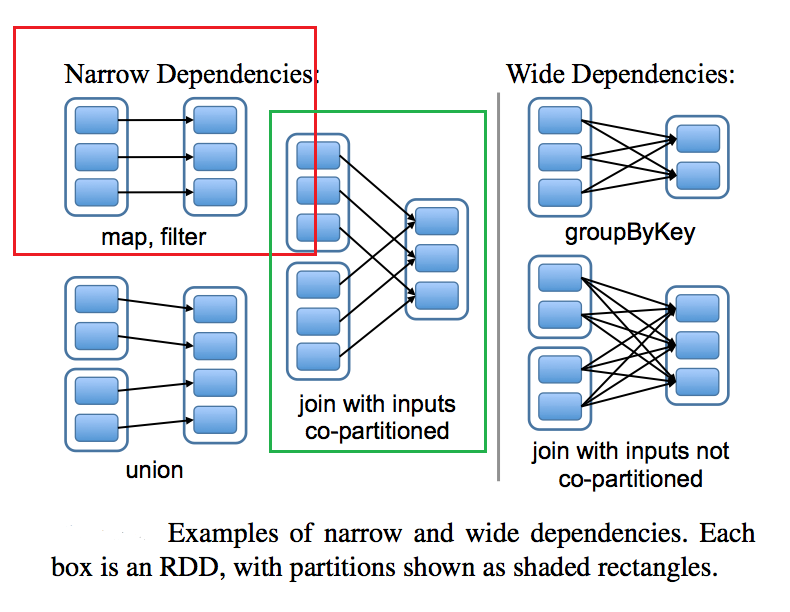

In [3]:
import time 

cores = 4
num_executors = 50
memory = '5g'
memory_overhead = '512m'
executor_memory = '1g'

In [4]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)
spark

In [5]:
small_df = spark.table("ke_matcher.ali_local_category_df").where(f.col("ds") == "20240715").withColumnRenamed('category_id', 'local_category_id')
print(small_df.cache().count())

9084


In [6]:
big_df = spark.table("ke_matcher.ali_item_df").where(f.col("ds") == "20240715").select("item_id", "local_category_id")
print(big_df.cache().count())

227849856


- number of partitions and number of executors are different
- partitions distributed unevenly (ApplicationMaster -> Storage -> {table name} -> Data Distribution)

In [7]:
start = time.time()

(
    big_df
    .orderBy(f.rand())
    .join(small_df, on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

59.84935808181763


* uneven task distribution

In [8]:
spark.stop()

In [9]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

small_df = spark.table("ke_matcher.ali_local_category_df").where(f.col("ds") == "20240715").withColumnRenamed('category_id', 'local_category_id')
print(small_df.cache().count())
big_df = spark.table("ke_matcher.ali_item_df").where(f.col("ds") == "20240715").select("item_id", "local_category_id")
print(big_df.cache().count())

9084
227849856


In [10]:
start = time.time()

(
    small_df
    .join(big_df.orderBy(f.rand()), on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

24.547136545181274


In [11]:
spark.stop()

### repartition big df

In [12]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

small_df = spark.table("ke_matcher.ali_local_category_df").where(f.col("ds") == "20240715").withColumnRenamed('category_id', 'local_category_id')
print(small_df.cache().count())
big_df = spark.table("ke_matcher.ali_item_df").where(f.col("ds") == "20240715").select("item_id", "local_category_id").repartition(num_executors * cores)
print(big_df.cache().count())

9084
227849856


In [13]:
start = time.time()

(
    big_df
    .join(small_df, on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

17.294583320617676


- tasks distribution a bit better

In [14]:
spark.stop()

### repartition both df

In [15]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

small_df = (
    spark.table("ke_matcher.ali_local_category_df")
    .where(f.col("ds") == "20240715")
    .withColumnRenamed('category_id', 'local_category_id')
    .repartition(num_executors * cores)
)
print(small_df.cache().count())
big_df = spark.table("ke_matcher.ali_item_df").where(f.col("ds") == "20240715").select("item_id", "local_category_id").repartition(num_executors * cores)
print(big_df.cache().count())

9084
227849856


In [16]:
start = time.time()

(
    big_df
    .join(small_df, on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

37.45998430252075


- very good task distribution

In [17]:
spark.stop()

### repartition by joining column

In [18]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

small_df = (
    spark.table("ke_matcher.ali_local_category_df")
    .where(f.col("ds") == "20240715")
    .withColumnRenamed('category_id', 'local_category_id')
    .repartition(num_executors * cores, 'local_category_id')
)
print(small_df.cache().count())
big_df = (
    spark.table("ke_matcher.ali_item_df")
    .where(f.col("ds") == "20240715")
    .select("item_id", "local_category_id")
    .repartition(num_executors * cores, 'local_category_id')
)
print(big_df.cache().count())

9084
227849856


In [19]:
start = time.time()

(
    big_df
    .join(small_df, on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

15.841824531555176


In [20]:
spark.stop()

### enable broadcasting

In [21]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=True
)

small_df = (
    spark.table("ke_matcher.ali_local_category_df")
    .where(f.col("ds") == "20240715")
    .withColumnRenamed('category_id', 'local_category_id')
    .repartition(num_executors * cores, 'local_category_id')
)
print(small_df.cache().count())
big_df = (
    spark.table("ke_matcher.ali_item_df")
    .where(f.col("ds") == "20240715")
    .select("item_id", "local_category_id")
    .repartition(num_executors * cores, 'local_category_id')
)
print(big_df.cache().count())

9084
227849856


In [22]:
start = time.time()

(
    big_df
    .join(small_df, on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

12.69487476348877


In [23]:
start = time.time()

(
    big_df
    .join(f.broadcast(small_df), on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

3.59328556060791


In [24]:
start = time.time()
(
    big_df
    .join(small_df.hint("broadcast"), on='local_category_id')
).count()

time_spent = time.time() - start
print(time_spent)

2.8745150566101074


In [25]:
spark.stop()

## GroupBy

In [26]:
import time 

cores = 4
num_executors = 50
memory = '5g'
memory_overhead = '1g'
executor_memory = '20g'

In [27]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

big_df = spark.table("ke_matcher.ali_item_sku_list_df").where((f.col("ds") == "20240715") & (f.col("is_online") == "Y")).orderBy(f.rand()).cache()
big_df.count()

3036620165

In [28]:
start = time.time()
(
    big_df
    .groupBy("item_id")
    .count()
).count()

time_spent = time.time() - start
print(time_spent)

104.51203656196594


In [29]:
spark.stop()

In [30]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

big_df = spark.table("ke_matcher.ali_item_sku_list_df").where((f.col("ds") == "20240715") & (f.col("is_online") == "Y")).cache()
big_df.count()

3036620165

In [31]:
start = time.time()
(
    big_df
    .groupBy("item_id")
    .count()
).count()

time_spent = time.time() - start
print(time_spent)

36.12400269508362


In [32]:
spark.stop()

In [33]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

big_df = spark.table("ke_matcher.ali_item_sku_list_df").where((f.col("ds") == "20240715") & (f.col("is_online") == "Y")).orderBy("item_id").cache()
big_df.count()

3036620165

In [34]:
start = time.time()
(
    big_df
    .groupBy("item_id")
    .count()
).count()

time_spent = time.time() - start
print(time_spent)

19.26470160484314


In [35]:
spark.stop()

In [36]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False
)

big_df = spark.table(
    "ke_matcher.ali_item_sku_list_df"
).where((f.col("ds") == "20240715") & (f.col("is_online") == "Y")).repartition(num_executors * cores, "item_id").cache()
big_df.count()

3036620165

In [37]:
start = time.time()
(
    big_df
    .groupBy("item_id")
    .count()
).count()

time_spent = time.time() - start
print(time_spent)

40.68900203704834


In [38]:
spark.stop()

# Union, или как перестать страдать

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.unionByName.html

# Histograms

(array([1.69095052e+08, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]),
 array([1.00020000e+04, 3.61608015e+17, 7.23216029e+17, 1.08482404e+18,
        1.44643206e+18, 1.80804007e+18, 2.16964809e+18, 2.53125610e+18,
        2.89286412e+18, 3.25447213e+18, 3.61608015e+18]),
 <BarContainer object of 10 artists>)

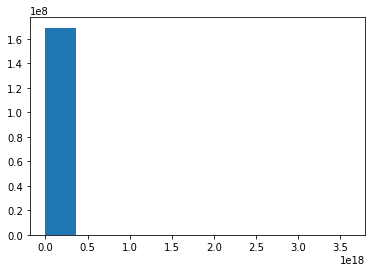

In [51]:
import matplotlib.pyplot as plt

bins, counts = big_df.select('item_id').rdd.flatMap(lambda x: x).histogram(10)
plt.hist(bins[:-1], bins=bins, weights=counts)

# Override Spark show method to pandas

In [52]:
# override show method to limit(n).toPandas()
from pyspark.sql.dataframe import DataFrame


def show(self, n=2):
    return self.limit(n).toPandas()


DataFrame.show = show

In [53]:
small_df.show(3)

,category_id,category_desc,category_level,is_leaf,category_lv1_id,category_lv1_desc,category_lv2_id,category_lv2_desc,category_lv3_id,category_lv3_desc,...,leaf_cate_id,category_lv5_desc,parent_category_id,parent_category_desc,category_path_ids,category_path_descs,category_path,category_group,category_type,res_language
0,403,Asciugamani,3,Y,15,Casa e giardino,405,Tessili per la casa,403,Asciugamani,...,403,Asciugamani,405,Tessili per la casa,"[15, 405, 403, 403, 403]","[Casa e giardino, Tessili per la casa, Asciuga...",Casa e giardino > Tessili per la casa > Asciug...,大美家,02,it
1,604,Lettori DVD e VCD,3,Y,44,Elettronica di consumo,100000308,Audio & Video per casa,604,Lettori DVD e VCD,...,604,Lettori DVD e VCD,100000308,Audio & Video per casa,"[44, 100000308, 604, 604, 604]","[Elettronica di consumo, Audio & Video per cas...",Elettronica di consumo > Audio & Video per cas...,大科技,02,it
2,629,Accessori e ricambi,2,N,44,Elettronica di consumo,629,Accessori e ricambi,629,Accessori e ricambi,...,629,Accessori e ricambi,44,Elettronica di consumo,"[44, 629, 629, 629, 629]","[Elettronica di consumo, Accessori e ricambi, ...",Elettronica di consumo > Accessori e ricambi,大科技,02,it


In [137]:
spark.stop()